In [398]:
# Copied from https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions
# Modified the code to make it more generic 
# Included "hard coded data" for Turkey and Republic of Ireland (ROI)

In [399]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Curve Fitting functions

## 1 - Logistic regression

In [400]:
# The logistic model describes an infection growth that is going to stop in the future, 

In [401]:
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



In [402]:
def calculate_sol_days(x, logistic_model_func, a_lr, b_lr, c_lr):
    # The expected infection end can be calculated as that particular day at which the cumulative 
    # infected people count is equal to the c parameter rounded to the nearest integer.
    sol_date = int(fsolve(lambda x : logistic_model_func(x, a_lr, b_lr, c_lr) - int(c_lr), b_lr))
    return sol_date

In [403]:
def print_sol_date(x, logistic_model_func, a_lr, b_lr, c_lr):
    # The expected infection end can be calculated as that particular day at which the cumulative 
    # infected people count is equal to the c parameter rounded to the nearest integer.
    sol_days = calculate_sol_days(x, logistic_model, a_lr,b_lr,c_lr)
    print("Days since new year: {}".format(sol_days)) 
    # check from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
    sol_date = datetime(2020,1,1) + timedelta(days=sol_days-1)
    print(sol_date.strftime("%d %B %Y"))

## 2 - Exponential growth

In [404]:
# The exponential model describes an unstoppable infection

In [405]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

## 3 - Generic code for curve fitting

In [406]:
def fit_curve(model_function, x, y, p0, population):
    # methods: [lm, trf, dogbox]
    # Method 'lm' only works for unconstrained problems. Use 'trf' or 'dogbox' instead.
    fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000, method="trf", 
                    bounds=(0, [np.inf, np.inf, population * 0.20]))
    #fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000, method="lm")
    # print("fit_result: {}".format(fit))
    a , b, c = fit[0]
    # standard error 
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    return a , b, c, errors

##  4 - Plot & evaluate

In [407]:
# TODO convert func, abc_tuple into struct and pass array of that struct
def plot_curves(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    sol = calculate_sol_days(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
    pred_x = list(range(max(x),sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    
    # Predicted logistic curve
    plt.plot(x+pred_x, 
             [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
             label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, 
             [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x+pred_x], 
             label="Exponential model" )
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,abc_tuple_lr[2]*1.1))
    plt.show()
    

def plot_curves_countries(logistic_model_func, country_2_abc_tuple_lr, country_2_xy):
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    
    for country, abc_tuple_lr in country_2_abc_tuple_lr.items():
        x = country_2_xy[country][0]
        y = country_2_xy[country][1]
        
        sol = calculate_sol_days(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
        pred_x = list(range(max(x),sol))
    
        # Real data
        plt.scatter(x,y, color="red")
    
        # Predicted logistic curve
        plt.plot(x+pred_x, 
                 [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
                 label="Logistic model({})".format(country))
        
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.show()

In [408]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
def calculate_mse(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    y_pred_logistic = [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x]
    y_pred_exp =  [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x]
    mse_lr = mean_squared_error(y,y_pred_logistic)
    mse_exp = mean_squared_error(y,y_pred_exp)
    return mse_lr, mse_exp

# Execute logistic regression & exponential growth

In [409]:
# Current date:
today = datetime.now()
print(today.strftime("%d %B %Y"))

28 March 2020


In [410]:
# generic parameters
days_since_start = 45 # predicted that after days_since_start maximum number of infections occurs
percentage_of_population = 0.03 # percentage_of_population predicted to be infected at the infection’s end
p0_a = 2

In [411]:
# To be used later
country_2_abc_tuple_lr = {}
country_2_xy = {}

## 1 - Data on Italy

### 1.1 - Load data

In [412]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [413]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
29,2020-03-24T17:00:00,ITA,21937,3396,25333,28697,54030,3612,8326,6820,69176,296964,NaN,NaN
30,2020-03-25T17:00:00,ITA,23112,3489,26601,30920,57521,3491,9362,7503,74386,324445,NaN,NaN
31,2020-03-26T17:00:00,ITA,24753,3612,28365,33648,62013,4492,10361,8165,80539,361060,pd-IT-0007,pd-EN-0007
32,2020-03-27T17:00:00,ITA,26029,3732,29761,36653,66414,4401,10950,9134,86498,394079,NaN,NaN
33,2020-03-28T17:00:00,ITA,26676,3856,30532,39533,70065,3651,12384,10023,92472,429526,NaN,NaN


In [414]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%dT%H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days  )

In [415]:
df.tail()

,data,totale_casi
29,83,69176
30,84,74386
31,85,80539
32,86,86498
33,87,92472


In [416]:
# Data
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

In [417]:
# p0: Initial guess for the parameters (length N)
population = 60.48 * 1e6# 60.48 million
start_date = 54 # 54th day of the year


p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population 
p0_lr = [p0_a, p0_b, p0_c ] 
p0_exp = [1,1,1]

### 1.2 - Execute Logistic Regression

In [418]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:5.325481580940731 , b_lr:81.72100411658327, c_lr:125042.94788279985 
errors_lr: [0.08018614691139984, 0.22530356135017326, 2348.1592490977177]


In [419]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 144
23 May 2020


### 1.3 - Execute Exponential Growth

In [420]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:14.85504399096622 , b_exp:0.11028674148208002, c_exp:6.957522662531302 
errors_exp: [3514675.9920351803, 0.004049954612316335, 2145300.6587169054]


### 1.4 - Plot

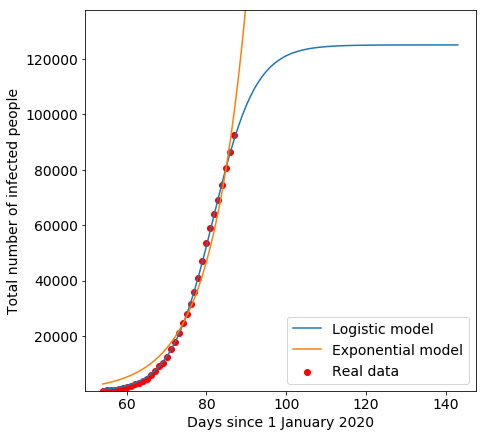

In [421]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 1.5 - Evaluate

In [422]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.

In [423]:
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 378636.44767964346
Exponential model MSE: 14886295.715074448


In [424]:
country = "Italy"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 2 - Data on Republic of Ireland

### 2.1 - Load data

In [425]:
# TODO Get data automatically from some source
# Starts at Feb 29
population = 4.83 * 1e6 # 4.83 million
start_date = 60 # start_date-th day of the year

total_cases = [1, 1, 1, 2 , 6, 13, 18, 19, 21, 24, 34, 43, 70, 90, 129, 169, 223, 292, 366, 557, 683, 785, 906, 1125,
              1329, 1564, 1819, 2121, 2415]
dates = list(range(start_date, start_date + len(total_cases)))

In [426]:
# Data
x = dates
y = total_cases

In [427]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population 
p0_lr = [p0_a, p0_b, p0_c] 
p0_exp = [1,1,1]

### 2.2 - Execute Logistic Regression

In [428]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:3.941364813654589 , b_lr:87.08011121377186, c_lr:4281.736853763173 
errors_lr: [0.12713609301833878, 0.5153901532418785, 287.49310283522436]


In [429]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 121
30 April 2020


### 2.3 - Execute Exponential Growth

In [430]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:2.3371545920094268 , b_exp:0.17848553142796128, c_exp:48.823719665396055 
errors_exp: [7035361.699504208, 0.005175129524782452, 16865374.810275946]


### 2.4 - Plot

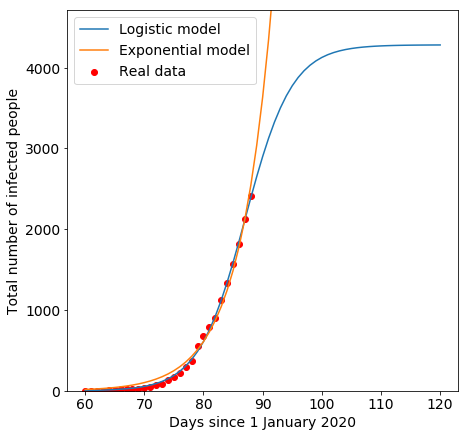

In [431]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 2.5 - Evaluate

In [432]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 660.5899192240482
Exponential model MSE: 3885.9640399375376


In [433]:
country = "RO_Ireland"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 3 - Data on Turkey

### 3.1 - Load data

In [434]:
# TODO Get data automatically from some source
# Starts at March 11
population = 80.81 * 1e6 # 80.81 million
start_date = 71 # start_date-th day of the year

total_cases = [1, 2, 5, 6, 18, 47, 98, 191, 358, 670, 947, 1236, 1529, 1872, 2433, 3629, 5698, 7402]
dates = list(range(start_date, start_date + len(total_cases)))

In [435]:
# Data
x = dates
y = total_cases

In [436]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population  
p0_lr = [p0_a, p0_b, p0_c] 
p0_exp = [1,1,1]

### 3.2 - Execute Logistic Regression

In [437]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:2.998585186532403 , b_lr:111.02469168243202, c_lr:16161999.836770106 
errors_lr: [0.30786403252202976, 1252.9038152701821, 6737970925.560274]


In [438]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 161
09 June 2020


### 3.3 - Execute Exponential Growth

In [439]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:1.7170820201153256 , b_exp:0.3334127668402094, c_exp:62.87021537569433 
errors_exp: [7591990.234103791, 0.012165053301094774, 13261187.975624247]


### 3.4 - Plot

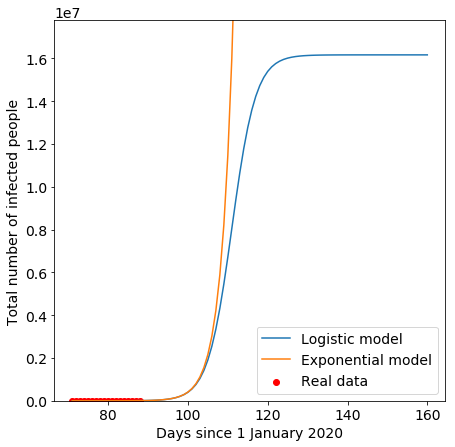

In [440]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 3.5 - Evaluate

In [441]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 24953.53018563382
Exponential model MSE: 24949.521419870496


In [442]:
country = "Turkey"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 4 - Plot all

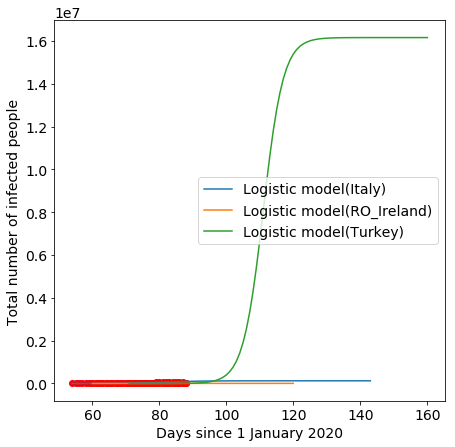

In [443]:
plot_curves_countries(logistic_model, country_2_abc_tuple_lr, country_2_xy)

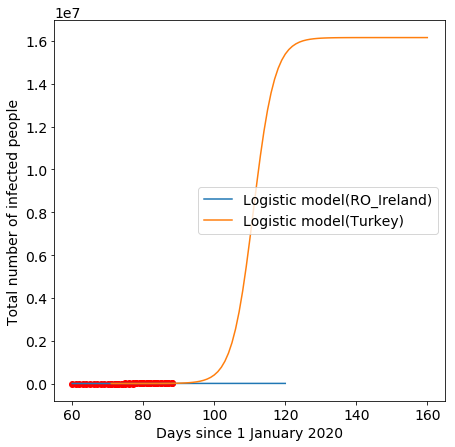

In [444]:
country_2_abc_tuple_lr.pop("Italy")
country_2_xy.pop("Italy")
plot_curves_countries(logistic_model, country_2_abc_tuple_lr, country_2_xy)